# Notebook 1: Generating the neutral hydrogen map

The following code generates a hydrogen map from theory:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from meer21cm import MockSimulation
from meer21cm.plot import plot_map

In [15]:
mock = MockSimulation(
    survey='meerklass_2021',
    band='L',
    ra_range=(334, 357),
    dec_range=(-35, -26.5),
    flat_sky=True,
    seed=42,
)


This gives you a survey area and the frequency range. This is the survey area:

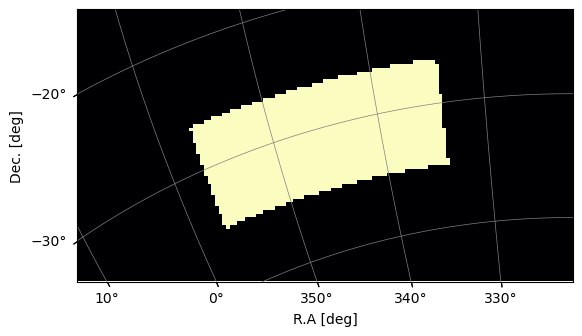

In [16]:
plot_map(mock.W_HI, mock.wproj, have_cbar=False)

And the frequency range gives you the cosmological redshifts:

Text(0, 0.5, 'Redshift')

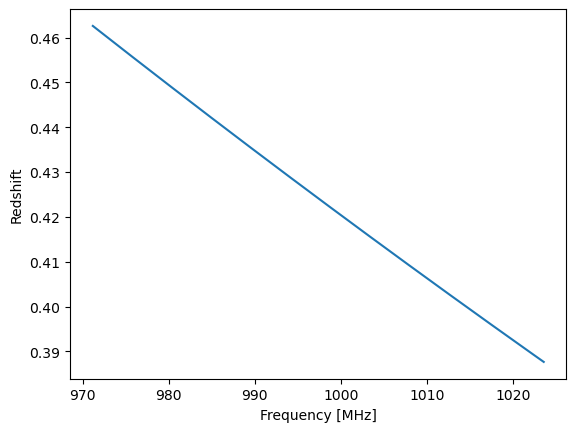

In [17]:
plt.plot(mock.nu/1e6, mock.z_ch)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Redshift')

And let us define some input model for the cosmological neutral hydrogen distribution:

In [18]:
mock.omega_hi = 5e-4 # neutral hydrogen fraction
mock.mean_amp_1 = 'average_hi_temp'
mock.tracer_bias_1 = 1.0 # bias of the neutral hydrogen distribution relative to the dark matter distribution


In [19]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)

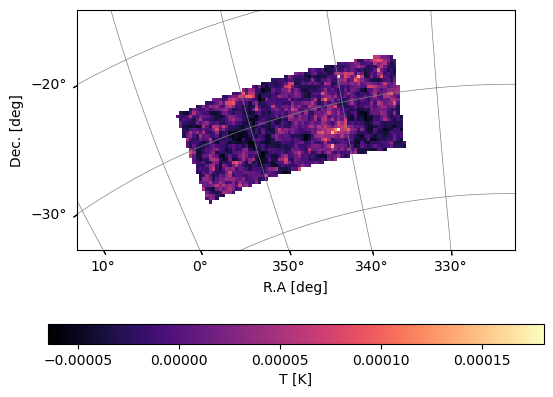

In [20]:
plot_map(mock.data, mock.wproj, W=mock.W_HI,have_cbar=True,cbar_label='T [K]')

Note that, this does not reflect the real observation. A real observation would include the telescope beam smoothing, foreground contamination, thermal noise and more potential systematics. For now, let us keep it simple and stick to just a 21cm signal.

## Power Spectrum
What we want to extract from the map is the power spectrum. It tells us how matter distributes in the Universe. From a theory perspective, the power spectrum is a function of ($k_\perp$, $k_\parallel$) 

In [27]:
mock.grid_data_to_field();

In [28]:
mock.kparabins = np.linspace(0, 1, 11)
mock.kperpbins = np.linspace(0, 0.5, 21)
power_cy,_ = mock.get_cy_power(mock.auto_power_3d_1)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1y/bkp6bf212cl3sq0d7bgcgtvm0000gn/T/ipykernel_63424/2084874477.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('k$_\perp$ [Mpc$^{-1}$]')
/var/folders/1y/bkp6bf212cl3sq0d7bgcgtvm0000gn/T/ipykernel_63424/2084874477.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('k$_\parallel$ [Mpc$^{-1}$]')


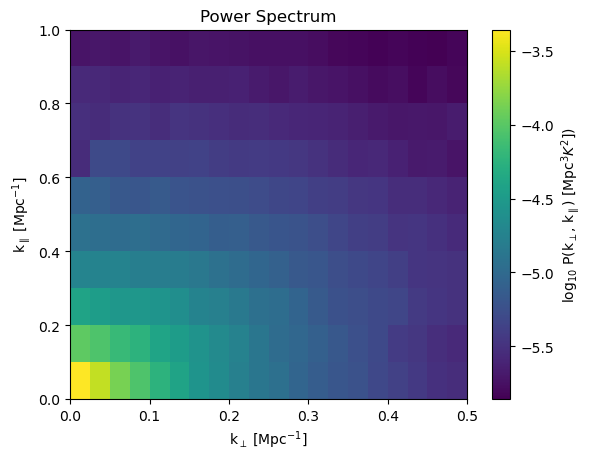

In [29]:
plt.pcolormesh(mock.kperpbins, mock.kparabins, np.log10(power_cy.T))
cbar = plt.colorbar()
cbar.set_label(r'log$_{10}$ P(k$_\perp$, k$_\parallel$) [${\rm Mpc}^{3}K^2]$)')
plt.xlabel('k$_\perp$ [Mpc$^{-1}$]')
plt.ylabel('k$_\parallel$ [Mpc$^{-1}$]')
plt.title('Power Spectrum')
plt.show()


In practice, we average the power spectrum into a 1D spectrum:

In [24]:
mock.k1dbins = np.linspace(0, 1.2, 21)
power_1d,k_1d,nmodes_1d = mock.get_1d_power(mock.auto_power_3d_1)

And let us compare with the input theory:

In [25]:
power_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)


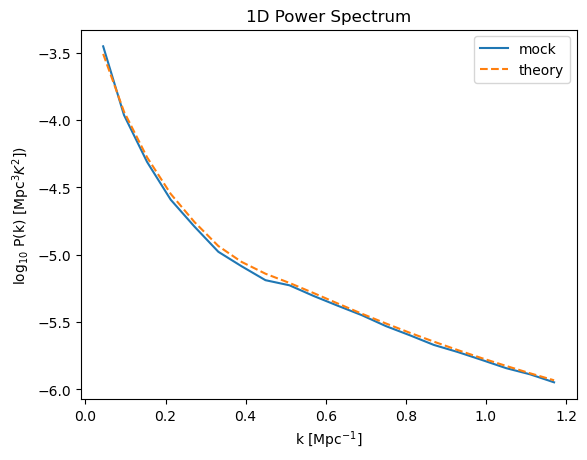

In [26]:
plt.plot(k_1d, np.log10(power_1d.T),label='mock')
plt.plot(k_1d, np.log10(power_model.T),label='theory',ls='--')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'log$_{10}$ P(k) [${\rm Mpc}^{3}K^2]$)')
plt.title('1D Power Spectrum')
plt.legend()
plt.show()



Task for you: If you go back to the beginning of the notebook, you can see that I specify `seed=42`. This is to say we use a fixed seed for random number generation, which gives you **one realization** of the mock. In order to put error bars on the blue line above, we need to change this seed to run multiple realizations. Organise the code snippets above into a function, that takes seed number as an input. Run 100 realisations and take the standard deviation of the 100 realizations as the error bar. Try it first yourself, don't worry if you can't finish it in time and we can go through this next week.

In [63]:
def generate_neutral_hydrogen_map(seeds):

    # create empty arrays to store data
    k_1d_list = []
    mock_power_1d_list = []
    theory_power_1d_list = []

    # iterate through the seeds array to run 100 realizations
    for i in range(len(seeds)):
        # print iteration of loop
        print(f"Running realisation {i} ...")

        # check if seed is an integer
        if not isinstance(seeds[i], (int, np.integer)):
            
            print("Error: The seed must be an integer.")
            return
        
        # generate a hydrogen map from theory
        # this gives a survey area and the frequency range
        # the frequency range gies the cosmological redshifts
        mock = MockSimulation(
        survey='meerklass_2021',
        band='L',
        ra_range=(334, 357),
        dec_range=(-35, -26.5),
        flat_sky=True,
        seed=seeds[i],
        )
    
        # define some input model for the cosmological neutral hydrogen distribution
        mock.omega_hi = 5e-4 # neutral hydrogen fraction
        mock.mean_amp_1 = 'average_hi_temp'
        mock.tracer_bias_1 = 1.0 # bias of the neutral hydrogen distribution relative to the dark matter distribution
    
        # this does not reflect the real observation, just the 21cm signal
        mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)
    
        # extract from the map the power spectrum (tells us the matter distribution in the Universe)
        mock.grid_data_to_field();
    
        mock.kparabins = np.linspace(0, 1, 11)
        mock.kperpbins = np.linspace(0, 0.5, 21)
        power_cy,_ = mock.get_cy_power(mock.auto_power_3d_1)
    
        # average the power spectrum into a 1D spectrum
        mock.k1dbins = np.linspace(0, 1.2, 21)
        power_1d,k_1d,nmodes_1d = mock.get_1d_power(mock.auto_power_3d_1)
    
        # compare with the input theory
        power_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)

        # appends data to data arrays
        k_1d_list.append(k_1d)
        mock_power_1d_list.append(np.log10(power_1d.T))
        theory_power_1d_list.append(np.log10(power_model.T))

    # take the means of the 100 realisations
    k_1d_list_mean = np.mean(k_1d_list, axis = 0)
    mock_power_1d_mean = np.mean(mock_power_1d_list, axis = 0)
    theory_power_1d_mean = np.mean(theory_power_1d_list, axis = 0)

    # take the standard deviations of the 100 realisations
    k_1d_list_std = np.std(k_1d_list, axis = 0)
    mock_power_1d_std = np.std(mock_power_1d_list, axis = 0)
    theory_power_1d_std = np.std(theory_power_1d_list, axis = 0)

    return k_1d_list_mean, mock_power_1d_mean, theory_power_1d_mean, k_1d_list_std, mock_power_1d_std, theory_power_1d_std


In [64]:
# generate a list of 100 integers [0, 1, 2, ..., 99]
seeds = np.arange(100)

# run the function to generate the neutral hydrogen map with 100 realisations
k_1d_list_mean, mock_power_1d_mean, theory_power_1d_mean, k_1d_list_std, mock_power_1d_std, theory_power_1d_std = generate_neutral_hydrogen_map(seeds)

Running realisation 0 ...
Running realisation 1 ...
Running realisation 2 ...
Running realisation 3 ...
Running realisation 4 ...
Running realisation 5 ...
Running realisation 6 ...
Running realisation 7 ...
Running realisation 8 ...
Running realisation 9 ...
Running realisation 10 ...
Running realisation 11 ...
Running realisation 12 ...
Running realisation 13 ...
Running realisation 14 ...
Running realisation 15 ...
Running realisation 16 ...
Running realisation 17 ...
Running realisation 18 ...
Running realisation 19 ...
Running realisation 20 ...
Running realisation 21 ...
Running realisation 22 ...
Running realisation 23 ...
Running realisation 24 ...
Running realisation 25 ...
Running realisation 26 ...
Running realisation 27 ...
Running realisation 28 ...
Running realisation 29 ...
Running realisation 30 ...
Running realisation 31 ...
Running realisation 32 ...
Running realisation 33 ...
Running realisation 34 ...
Running realisation 35 ...
Running realisation 36 ...
Running rea

In [107]:
def save_project_plot(fig, week_number, filename):
    """
    Saves a matplotlib figure to a specific week's folder.
    Example: week_number=1 saves to .../outputs/week1/
    """
    # 1. Define the base path
    base_path = "/Users/gracetait/shproject/senior_honours_project/outputs"
    
    # 2. Create the week-specific folder name
    week_folder = f"week{week_number}"
    
    # 3. Combine them into a full path
    target_dir = os.path.join(base_path, week_folder)
    
    # 4. Create the directory if it doesn't exist yet
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created new directory: {target_dir}")
    
    # 5. Define the final file path
    save_path = os.path.join(target_dir, filename)
    
    # 6. Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Successfully saved: {save_path}")

Successfully saved: /Users/gracetait/shproject/senior_honours_project/outputs/week1/1D_power_spectrum_neutral_hydrogen_map_100_realisations.pdf


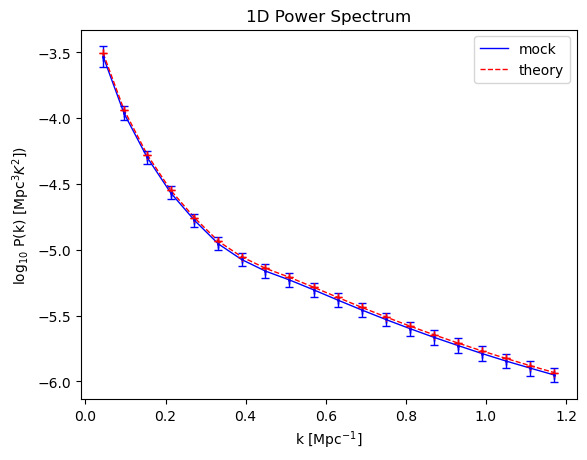

In [108]:
# plot the 1D power spectrum
plt.plot(k_1d_list_mean, mock_power_1d_mean, label='mock', color = 'blue', linewidth = 1)
plt.plot(k_1d_list_mean, theory_power_1d_mean, label='theory',ls='--', color = 'red', linewidth = 1)
plt.errorbar(k_1d_mean, mock_power_1d_mean, yerr = mock_power_1d_std, xerr = k_1d_std, fmt = 'o', capsize = 3, color = 'blue', markersize = 1, linewidth = 1)
plt.errorbar(k_1d_mean, theory_power_1d_mean, yerr = theory_power_1d_std, xerr = k_1d_std, fmt = 'None', capsize = 3, color = 'red', markersize = 1, linewidth = 1)

# add title and labels
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'log$_{10}$ P(k) [${\rm Mpc}^{3}K^2]$)')
plt.title('1D Power Spectrum')
plt.legend()

# save plot to outputs file
# use plt.gcf() to grab the plot
save_project_plot(plt.gcf(), week_number = 1, filename = "1D_power_spectrum_neutral_hydrogen_map_100_realisations.pdf")

# show plot
plt.show()